<a href="https://colab.research.google.com/github/Priestly101/ai_projects/blob/main/Lesson_8_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
# !pip install torch==1.8.0
from fastai import *
from fastai.collab import *
from fastai.tabular.all import *

     |████████████████████████████████| 727kB 8.8MB/s 
     |████████████████████████████████| 194kB 14.3MB/s 
     |████████████████████████████████| 1.2MB 15.9MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 12.8MB 25.6MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.


In [2]:
# Getting the data for collaborative filtering.
path = untar_data(URLs.ML_100k)

In [3]:
path.ls() # Main data is in u.data

(#23) [Path('/root/.fastai/data/ml-100k/u1.base'),Path('/root/.fastai/data/ml-100k/u2.base'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/u5.base'),Path('/root/.fastai/data/ml-100k/ua.test'),Path('/root/.fastai/data/ml-100k/ub.base'),Path('/root/.fastai/data/ml-100k/README'),Path('/root/.fastai/data/ml-100k/u5.test'),Path('/root/.fastai/data/ml-100k/u1.test'),Path('/root/.fastai/data/ml-100k/u.item')...]

In [4]:
ratings = pd.read_csv(path/"u.data", delimiter="\t", names=["user", "movie", "rating", "timestamp"], header=None)
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
labels = pd.read_csv(path/"u.item", delimiter="|", encoding="latin-1", usecols=(0,1), names=('movie','title'), header=None)
labels

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [6]:
ratings = pd.merge(ratings, labels)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [7]:
dls = CollabDataLoaders.from_df(ratings, item_name="title", bs=64)
dls.show_batch()

,user,title,rating
0,910,Toy Story (1995),4
1,870,Manhattan (1979),2
2,542,"Empire Strikes Back, The (1980)",4
3,655,Ladybird Ladybird (1994),3
4,297,Mary Poppins (1964),3
5,7,"American in Paris, An (1951)",3
6,339,Trees Lounge (1996),5
7,643,"Usual Suspects, The (1995)",5
8,680,Unforgiven (1992),3
9,537,Stand by Me (1986),3


In [8]:
dls.classes # Use this to see what classes are used for what data in your DLS object.

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [9]:
siz_recmndd_embs = get_emb_sz(dls)
siz_recmndd_embs

[(944, 74), (1665, 102)]

In [10]:
# Im going to use this cell to make the model from scratch.
# I will do one using the embeddings class, one without and one using deep learning.

# USING NON NN WAY
len_movies = len(dls.classes["title"])
len_users = len(dls.classes["user"])
# latent_factors = 50

"""
I decided to just instantiate these inside of the class.
movie_factors =
user_factors = 
def Embeddings(*size):
  return nn.Parameter(torch.ones(*size).normal_(0, 0.01))
"""

class DotProductBias(Module):
  def __init__(self, len_users, len_movies, latent_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(len_users, latent_factors)
    self.user_bias = Embedding(len_users, 1)
    self.movie_factors = Embedding(len_movies, latent_factors)
    self.movie_bias = Embedding(len_movies, 1)
    self.y_range = y_range

  def forward(self, x): # Takes the pandas df as single input.
    user_embs = self.user_factors(x[:,0])
    movie_embs = self.movie_factors(x[:,1]) # y_range must be between 0.5 and 5.5 for the ratings.
    results = (user_embs*movie_embs).sum(dim=1, keepdim=True) # Was just gonna make an array for embs but kept getting error.
    results += (self.user_bias(x[:,0]) +  self.movie_bias(x[:,1]))
    return sigmoid_range(results, *self.y_range)


# USING THE NN WAY
len_movies = len(dls.classes["title"])
len_users = len(dls.classes["user"])
#latent_factors = 50
siz_recmndd_embs = get_emb_sz(dls) # Recommended embedding sizes but just placed inside an tuple.

"""
When using args you have to pay attention to the order of items in the array of 
args. This matters when calling them/creating variables for them in your code.
"""

class CollabNN(Module):
  def __init__(self, emb_size_users, emb_size_movies, y_range=(0,5.5), n_activations=100):
    self.user_factors = Embedding(*emb_size_users) # Gets first item in the *args array
    self.movie_factors = Embedding(*emb_size_movies) # Gets second item in the *args array
    self.layers = nn.Sequential(
        nn.Linear(emb_size_users[1] +emb_size_movies[1], n_activations),
        nn.ReLU(),
        nn.Linear(n_activations, 1))
    self.y_range = y_range
  
  def forward(self, x):
    siz_recmndd_embs = self.user_factors(x[:,0]),self.movie_factors(x[:,1])
    x = self.layers(torch.cat(siz_recmndd_embs, dim=1)) # the same as doing the dotproduct, just using layers.
    return sigmoid_range(x, *self.y_range)
"""
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)
"""

'\nclass CollabNN(Module):\n    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):\n        self.user_factors = Embedding(*user_sz)\n        self.item_factors = Embedding(*item_sz)\n        self.layers = nn.Sequential(\n            nn.Linear(user_sz[1]+item_sz[1], n_act),\n            nn.ReLU(),\n            nn.Linear(n_act, 1))\n        self.y_range = y_range\n        \n    def forward(self, x):\n        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])\n        x = self.layers(torch.cat(embs, dim=1))\n        return sigmoid_range(x, *self.y_range)\n'

In [11]:
# Non NN learner
model = DotProductBias(len_users, len_movies, 50) # Using 60 latent fatcors
learn = Learner(dls, model=model, loss_func=MSELossFlat(), wd=0.1)
learn.fit_one_cycle(3, 3e-3) # Modle overfits somewhere between 2nd and 3rd epoch.
# Using 3 epochs and smaller lr.

epoch,train_loss,valid_loss,time
0,0.929118,0.925200,00:10
1,0.831851,0.852653,00:10
2,0.763115,0.840662,00:10


In [12]:
# Collab_learner no NN
learn = collab_learner(dls, n_factors=50, y_range=(0,5.5)) # No need to perform calback.
learn.fit_one_cycle(4, 3e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.982942,0.951765,00:10
1,0.857308,0.859630,00:10
2,0.739958,0.828376,00:10
3,0.687675,0.826778,00:10


In [13]:
# Collab_learner NN
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 4e-3, wd=0.1)


epoch,train_loss,valid_loss,time
0,1.000366,0.984616,00:17
1,0.928535,0.910297,00:17
2,0.889066,0.883505,00:17
3,0.821571,0.858102,00:17
4,0.750075,0.859988,00:17


In [14]:
# NN learner
model = CollabNN(*siz_recmndd_embs)
learn = Learner(dls, model=model, loss_func=MSELossFlat()) # Using weight decay. Just adds to gradient for better generalistion.
#
learn.fit_one_cycle(5, 4e-3, wd=0.1)



epoch,train_loss,valid_loss,time
0,0.927441,0.951360,00:12
1,0.928102,0.895187,00:12
2,0.878175,0.875647,00:12
3,0.835339,0.857271,00:12
4,0.771954,0.856074,00:12


In [15]:
np.argsort(learn.model.movie_factors.weight.detach().numpy(), axis=-1) #.weight[:, :].

array([[ 60,  91,   8, ...,  81,  76,  41],
       [ 58,  46,  83, ...,  76,  32,  30],
       [  1,  67,  92, ...,  28,  43,  76],
       ...,
       [ 76,  43,  28, ...,  57,  67,   1],
       [  1,  67,  57, ...,  28,  43,  76],
       [ 30, 100,  37, ...,  46,  27,  66]])

In [16]:
get_emb_sz(dls)

[(944, 74), (1665, 102)]

In [63]:
"""
Imma just do PCA with my other data in these cells.
"""
def plot_pca(collab_dset, num_pca_cols, num_values_to_analyse, embs_factors_num_items, args):
  groupby_collab_dset = collab_dset.groupby("title")["rating"].count()
  best_items = groupby_collab_dset.sort_values(ascending=False).index.values[:num_values_to_analyse]
  indx_best_items = [learn.dls.classes['title'].o2i[item] for item in best_items]
  item_weights = learn.model.movie_factors.weight[indx_best_items].cpu().detach()
  item_pca = item_weights.pca(num_pca_cols)
  pca_cols = item_pca.t().detach().numpy()
  #pca_cols = [pca_cols]     
  # Can only be a single scalar.
  idxs = list(range(embs_factors_num_items[1])) # Input only the length of the pca columns.
 
  # Plotting factors, with labels.
  X = pca_cols[0]
  Y = pca_cols[1]
  plt.figure(figsize= args[0])
  plt.scatter(X,Y)
  plt.xlabel("First PCA Set")
  plt.ylabel("Second PCA Set")

  for i,x,y in zip(best_items[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(num_pca_cols)*0.8, fontsize=11)
  plt.show()
  print("Only the labels for the items with the highest embeddings are shown.")

  # I'm gonna make a function to display all the pca cols plotted against each other 






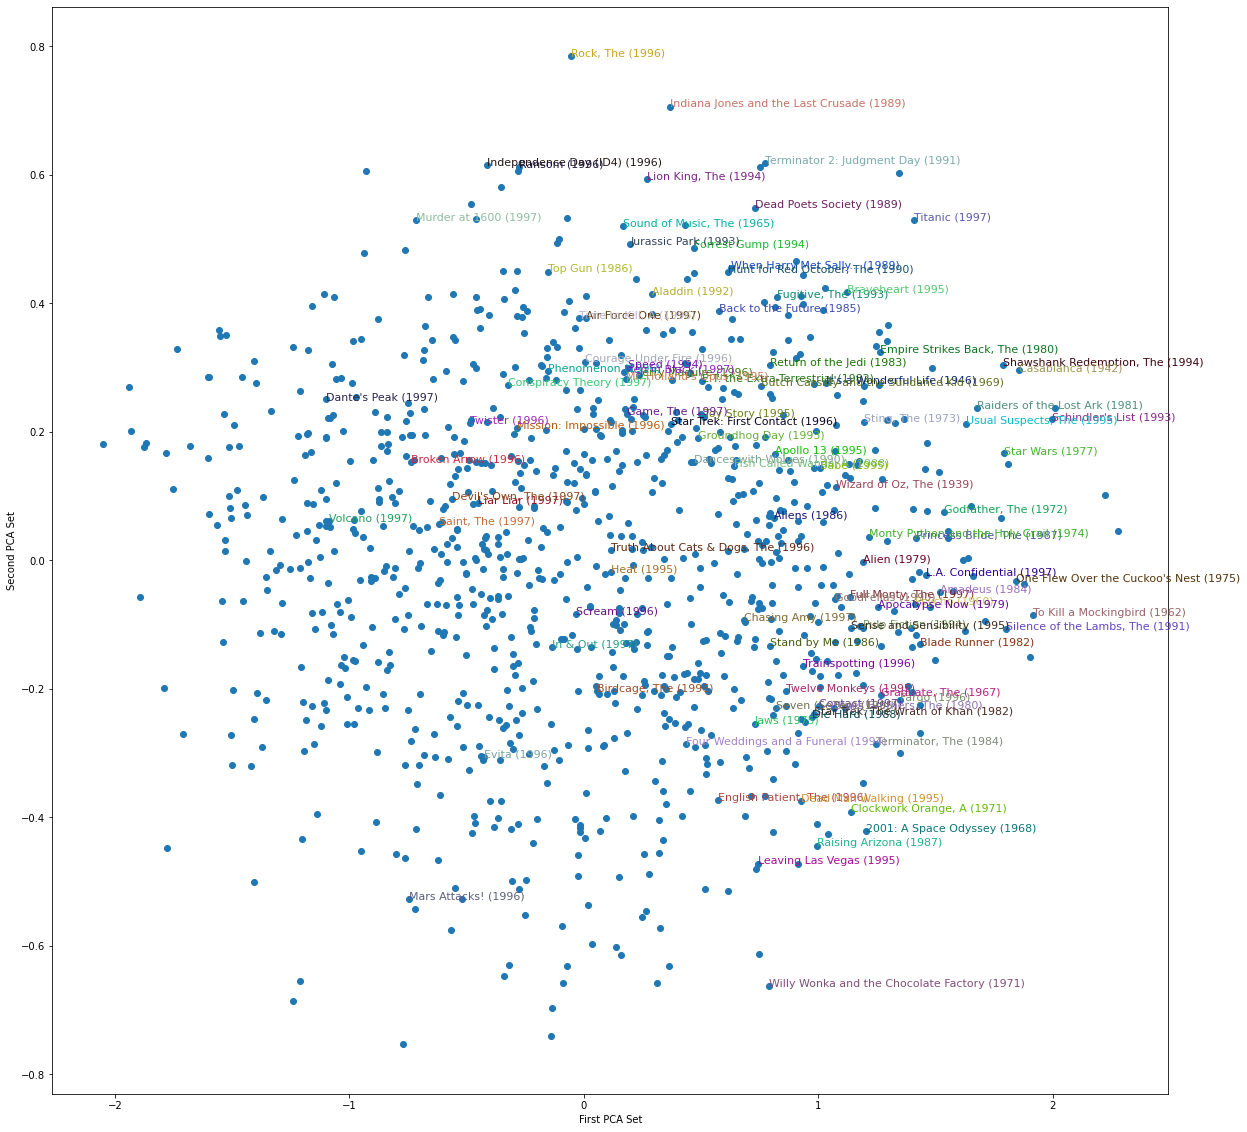

Only the labels for the items with the highest embeddings are shown.


In [64]:
plot_pca(ratings, 3, 1000, siz_recmndd_embs[1], [(20,20)]) # Using embs for movies.

In [19]:
learn.dls.classes['title'][0]


'#na#'

In [20]:
siz_recmndd_embs[1][1]

102

In [21]:
learn.model.movie_factors.weight[1]


tensor([-0.0387,  0.1337,  0.1079,  0.1332,  0.0821,  0.1238,  0.0380,  0.1072,
        -0.1253,  0.1118,  0.1340,  0.1284,  0.1315,  0.1233, -0.1284,  0.1266,
         0.1305,  0.1214, -0.0826,  0.1224, -0.0740, -0.1369, -0.1343,  0.0655,
         0.1301, -0.0255,  0.1304,  0.0704,  0.0746,  0.1293,  0.1351,  0.1034,
         0.0849, -0.0068,  0.0434, -0.0174,  0.1360,  0.1332, -0.0799, -0.1269,
         0.1299, -0.0867, -0.0712,  0.1290, -0.1267,  0.0191,  0.1018,  0.1213,
        -0.0846, -0.0994, -0.1321, -0.0779,  0.1287, -0.0312, -0.0236,  0.1208,
         0.0256, -0.1257, -0.1305, -0.1337,  0.1224, -0.1295,  0.1316, -0.1282,
         0.0192, -0.0774, -0.0413, -0.1283, -0.1306, -0.1348, -0.0721,  0.1018,
        -0.1346, -0.1052, -0.1134,  0.1256, -0.0830, -0.0726, -0.1286,  0.1140,
        -0.1371,  0.0644, -0.0707,  0.1367, -0.0776,  0.1313,  0.1081, -0.1318,
         0.1232,  0.1205,  0.1263,  0.0978, -0.1252,  0.1299, -0.0932, -0.1219,
         0.1238,  0.1046, -0.1271,  0.03